# Training CNN

In [1]:
%pylab inline 
import numpy as np
import cv2
from sklearn.utils import shuffle
from scipy.misc import imresize
import pandas as pd
import os

from keras.models import Model
from keras.layers import Cropping2D, Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.layers import Lambda, concatenate, Activation
from keras import initializers
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
from keras.models import Sequential

In [3]:
import pickle
pylab.rcParams['figure.figsize'] = (7, 6)

## Load dataset

In [4]:
data_path = './data/data/'

In [5]:
headers = 'center,left,right,steering,throttle,brake,speed'.split(',')
path = data_path+'driving_log.csv'
log = pd.read_csv(path)
log.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [6]:
def read_line(path, line, camera, offset=0):
    ipath = line[camera].strip()
    path = os.path.join(path, ipath)
    #print(path)
    image = cv2.imread(path)
    if image is None:
        print('cant open an image', path)
        return (None, None)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    steering = float(line['steering'])
    if abs(steering) < (1 - abs(offset)):
        steering += offset
    return steering, image_rgb

In [7]:
strn, imgrgb = read_line(data_path, log.iloc[4000], 'center')

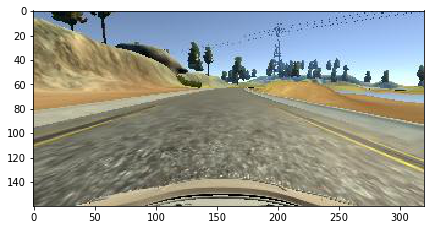

In [8]:
imshow(imgrgb)

In [54]:
images_rgb = []
steerings = []

def readAllImgs(logs, path):
    err = 0    
    def readAndAppend(path, en, camera, offset):
        steering, rgb = read_line(path, en, camera, offset)
        if rgm is None:
            return False
        steerings.append(steering)
        images_rgb.append(rgb)
        return True
    
    for i,en in log.iterrows():
        ret = readAndAppend(path, en, 'center', 0)
        if not ret:
            err += 1
            continue
        readAndAppend(path, en, 'left', 0.2)
        readAndAppend(path, en, 'right', -0.2)
    print(err)
    
readAllImgs(log, data_path)


0


#### Histogram of steerings
Excluding zeros

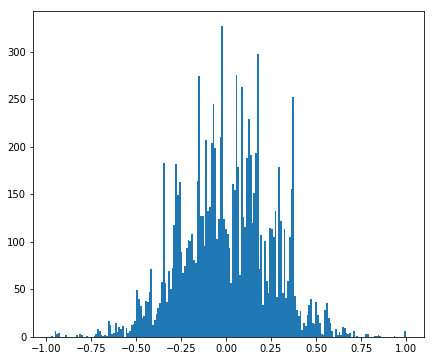

In [64]:
pyplot.hist([x for x in steerings if x!=0 and abs(x)!=0.2], bins=200)
plt.show()

## Building model

In [9]:
def buildModel():
    model = Sequential()
    # normalize data
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
    # crop road part
    model.add(Cropping2D(cropping=((50,20), (0,0))))
    # CNN (ref: NVIDIA End-to-end model)
    model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(36, (5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(48,(5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(1))
    return model

In [10]:
model = buildModel()

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 33, 64)         36928     
__________

In [12]:
model.compile('adam', 'mse')

### Prepare data

In [99]:
XA = np.array(images_rgb)
YA = np.array(steerings)

In [ ]:
pickle.dump({'rgb':XA, 'y': YA}, open('data/rgb.p', 'wb'))

In [19]:
data = pickle.load(open('data/rgb.p', 'rb'))

In [22]:
XA = data['rgb']
YA = data['y']

#### Append symmetrical data
##### Flip all the pictures vertically

In [24]:
XB = np.flip(XA, axis=2)
YB = YA * (-1)

#### Concatenate arrays together

In [26]:
X = np.concatenate((XA, XB))
Y = np.concatenate((YA, YB))

In [27]:
del XA
del XB
del data

#### add random factor

In [28]:
X, Y = shuffle((X,Y))

In [29]:
print(X.shape)

(48216, 160, 320, 3)


In [30]:
data_size = 1
for x in X.shape:
    data_size *= x
print(data_size / (1024*1024*1024), 'Gb of training/testing data')

6.8973541259765625 Gb of training/testing data


### Train the model

In [31]:
model.fit(X,Y, batch_size=128, epochs=2, verbose=2, validation_split=0.14)

Train on 41465 samples, validate on 6751 samples
Epoch 1/2
123s - loss: 0.0175 - val_loss: 0.0164
Epoch 2/2
115s - loss: 0.0130 - val_loss: 0.0198


In [32]:
model.save('models/modelNv02.h5')

# Visualize

In [2]:
from IPython.display import HTML

In [3]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/ZUaHttB-yYE" frameborder="0" allowfullscreen></iframe>')